# ISOMAP LAB.3 Solutions

First of all let's import the useful modules.

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # csv manipulation
from sklearn.model_selection import train_test_split # for train test split
from sklearn.linear_model import LogisticRegression # for classification
from sklearn.neighbors import NearestNeighbors # for nearest neighbors
import numba as nb # speeding up computations
from sklearn.preprocessing import OrdinalEncoder  # for preprocessing
from sklearn.utils.graph import _fix_connected_components # for connecting unconnected graphs
from scipy.sparse.csgraph import connected_components # for counting connected components in a graph


## Exercise 1

We first implement classical multidimensional scaling as a class.

In [3]:
class MDS(object):
    """
    Perform classical multidimensional scaling. 
    We assume that the returned coordinate matrix have mean 0.
    """
    def __init__(self):
        
        self.eigenvalues = None
        self.eigenvect = None
        self.n_components = None

    def fit(self, X):

        # get matrix shape
        n = X.shape[0]

        # centering matrix 
        C = np.eye(n) - 1./n * np.ones((n, n))

        # double centering matrix
        B = -0.5 * np.dot(C, np.dot(X**2, C))

        # decompose double centering matrix
        eigvalues, eigvects = np.linalg.eigh(B)

        # sort in ascending order + sqrt eigenvalues
        idx = eigvalues.argsort()[::-1]
        
        self.eigenvalues = eigvalues[idx]
        self.eigenvect = eigvects[:, idx]


    def transform(self, x, numb_components = None):

        # check consistency number of components
        numb_components = self._check_numb_components(x, numb_components)

        if (self.eigenvalues is None) or (self.eigenvect is None):
            raise ValueError('transform method called before fit method.')
            
        # choose the eigenvect/eigenval according to the number of components
        eigvalues = self.eigenvalues[:numb_components]
        eigenvect = self.eigenvect[:, :numb_components]

        return np.dot(eigenvect, np.diag(np.sqrt(eigvalues)))

    def _check_numb_components(self, x, numb_components):
        """
        Expect input shape to be numb_sample X dimension_sample. 
        """
        # number of samples and features
        _, n_features = x.shape

        # check consistency
        if numb_components is None:
            numb_components = n_features

        if numb_components < 1 or numb_components > n_features:
            raise ValueError("numb_components must be greater or equal than one"
                            " and smaller or equal to the number of features")

        return numb_components


We also implement Floyd-Warshall algorithm, using numba as an accellerator. Notice that to use just in time compilation the program needs a warm up phase before.

In [4]:
@nb.njit()
def floyd_warshall(input_matrix):
    """Floyd-warshall algorithm for shortest path

    :param input_matrix: A matrix representing a connected graph, inf as default for not connection expected
    :type input_matrix: np.ndarray
    :return: The matrix of shortest maths 
    :rtype: np.ndarray
    """
    for i in range(input_matrix.shape[0]):
        for j in range(input_matrix.shape[0]):
            if i != j and input_matrix[i, j] == 0:
                input_matrix[i, j] = np.inf

    for k in range(input_matrix.shape[0]):
        for i in range(input_matrix.shape[0]):
            for l in range(input_matrix.shape[0]):
                input_matrix[i, l] = min(input_matrix[i, l], input_matrix[i, k] + input_matrix[k, l])

    return input_matrix


The ISOMAP is implemented as a class, following the same schema as `scikit-learn`.

In [5]:
class ISOMAP(object):
    
    def __init__(self, n_neighbors=5, metric='minkowski', p=2, optimization_alg=None):
        
        # Nearest Neighbors
        self.neigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, p=p)

        # Multidimensional scaling
        self.mds = MDS()

        # Shortest path algorithm 
        if optimization_alg is None:
            raise ValueError('expected an optimization algorithm for finding shortest path')
        else:
            self.optimization_alg = optimization_alg

        # Check algorithm shortest path consistency
        self._warm_up_and_check()

        # Infinity threshold
        self.inf = np.inf

    def fit(self, X):

        # perform NN
        self.neigh.fit(X)

        # create graph
        graph = self.neigh.kneighbors_graph(X, mode='distance').toarray()

        # connecting graph
        n_connected_components, labels = connected_components(graph)
        graph = _fix_connected_components(X=self.neigh._fit_X, 
                                          graph=graph,
                                          n_connected_components=n_connected_components,
                                          component_labels=labels,
                                          mode="distance",
                                          metric=self.neigh.effective_metric_,
                                          **self.neigh.effective_metric_params_
                                          )
        
        # apply shortest path
        shortG = self.optimization_alg(graph)

        # symmetrize the matrix
        G = self._nearest_neigh_symmetrize(shortG)

        # apply MDS
        self.mds.fit(G)

    def transform(self, x, numb_components=None):
        """Tranform input using ISOMAP

        :param x: input matrix [numb_sample, dimension_sample]
        :type x: np.ndarray
        :param numb_components: number of components to keep with MDS, defaults to None
        :type numb_components: int, optional
        :return: lower dimensional representation matrix [numb_sample, numb_components]
        :rtype: np.ndarray
        """
        return self.mds.transform(x, numb_components)

    def _warm_up_and_check(self):
        G = np.array([[0, 3, np.inf, 5, 10, 2, np.inf],
                      [2, 0, np.inf, 4, np.inf, 4, 0],
                      [np.inf, 1, 0, np.inf, 0, 1, 1],
                      [np.inf, np.inf, 2, 0, 2, np.inf, 3],
                      [0, np.inf, 4, np.inf, 4, 0, 1],
                      [1, 0, np.inf, 0, 1, 1, 5],
                      [np.inf, 2, 0, 2, np.inf, 3, 1]])
        self.optimization_alg(G)

    def _nearest_neigh_symmetrize(self, X):

        # put diagonal elements to zero
        np.fill_diagonal(X, 0.)

        for i in range(X.shape[0]):
            for j in range(i+1, X.shape[0]):
                value = min(X[i, j], X[j, i])
                X[i, j] = X[j, i] = value

        return X

    

Once the ISOMAP class is defined we can proceede with the exercise.

In [6]:
def swiss_roll(n, noisy=False):
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
    noise_x = noise_y = 0

    if noisy:
        noise_x = np.random.normal(0, 0.5, n)
        noise_y = np.random.normal(0, 0.5, n)

    data[:,0]=phi*np.cos(phi) + noise_x #x coordinte
    data[:, 1] = phi*np.sin(phi) + noise_y # y coordinate
    data[:,2]=psi #z coordinate
    return data


Let's use ISOMAP and plot

In [7]:
data = swiss_roll(1000)
iso = ISOMAP(n_neighbors=15, optimization_alg=floyd_warshall)
iso.fit(data)

Let's plot the results

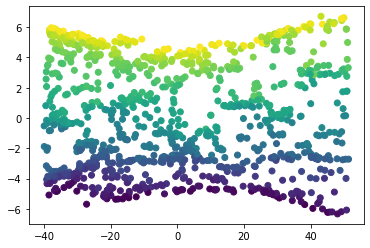

In [8]:
y = iso.transform(data, 2)
plt.scatter(y[:, 0], y[:, 1], c=data[:, -1])
plt.show()


Since our own implementation of `FloydWarshall` takes some time, even if we used just in time compilation, we switch to `scipy.sparse.csgraph.shortest_path`. Let's try again the same thing but with 5000 points.

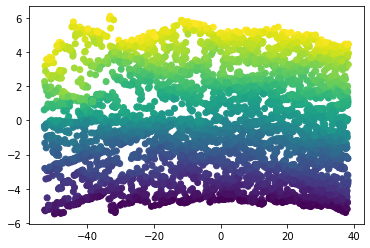

In [9]:
from scipy.sparse.csgraph import shortest_path

data = swiss_roll(5000)
iso = ISOMAP(n_neighbors=15, optimization_alg=shortest_path)
iso.fit(data)
y = iso.transform(data, 2)
plt.scatter(y[:, 0], y[:, 1], c=data[:, -1])
plt.show()


As we can see, we obtain a perfect plane, as expected. Let's try to add some noise to the swiss role, and test different number of neighboors

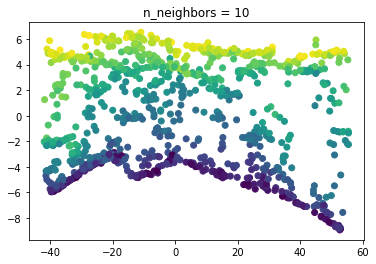

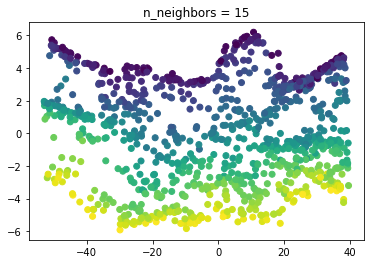

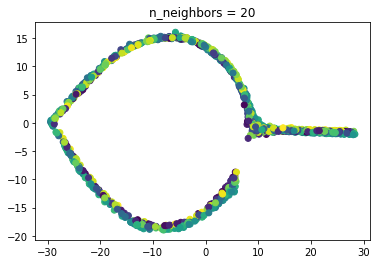

<Figure size 432x288 with 0 Axes>

In [20]:
data = swiss_roll(1000, noisy=True)

for n_neighbors in [10, 15, 20]:
    plt.title(f'n_neighbors = {n_neighbors}')
    iso = ISOMAP(n_neighbors=n_neighbors, optimization_alg=shortest_path)
    iso.fit(data)
    y = iso.transform(data, 2)
    plt.scatter(y[:, 0], y[:, 1], c=data[:, -1])
    plt.show()
    plt.figure()



And let's also try without noise.

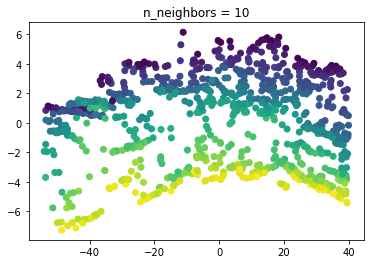

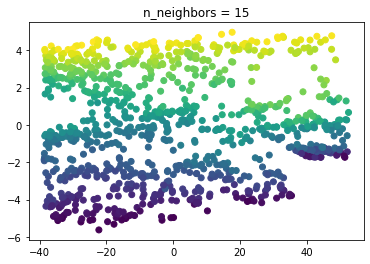

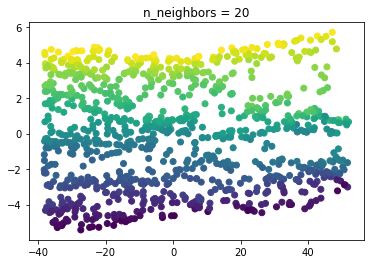

<Figure size 432x288 with 0 Axes>

In [19]:
data = swiss_roll(1000, noisy=False)

for n_neighbors in [10, 15, 20]:
    plt.title(f'n_neighbors = {n_neighbors}')
    iso = ISOMAP(n_neighbors=n_neighbors, optimization_alg=shortest_path)
    iso.fit(data)
    y = iso.transform(data, 2)
    plt.scatter(y[:, 0], y[:, 1], c=data[:, -1])
    plt.show()
    plt.figure()

As we can see, by increasing the number of neighboors it starts loosing the local structure when noise it is added. This is because ISOMAP is very noise sensitive, especially when the number of neighboors increases.

## Exercise 2

Let's first import the dataset

In [21]:
# get the dataframe
df = pd.read_excel('../Datasets/Dry_Bean_Dataset.xlsx')

# create matrix for data in numpy ndarray
y = df['Class']
X = df.drop('Class', axis=1)
encoder = OrdinalEncoder()
y = np.array(y)
encoder.fit(y.reshape(-1, 1))
y = encoder.transform(y.reshape(-1, 1))

# split to train and 
X, _, y, _ = train_test_split(X, y, train_size=1000)

# split train test set
X_train, X_test, target_train, target_test = train_test_split(X, y, test_size=0.2)

# normilize
X_train = (X_train - X_train.mean())/(X_train.std())
X_test = (X_test - X_test.mean())/X_test.std()
target_test = target_test.ravel()


Let's train the classifier

In [24]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

for numb_components in range(1, X.shape[1]+1):
    
    # training
    isomap = ISOMAP(n_neighbors=50, optimization_alg=shortest_path)
    isomap.fit(X_train) 
    y_train = isomap.transform(X_train, numb_components)
    model = LogisticRegression(multi_class='multinomial')
    model.fit(y_train, target_train)
    score_train = model.score(y_train, target_train)

    # testing
    isomap = ISOMAP(n_neighbors=50, optimization_alg=shortest_path)
    isomap.fit(X_test)
    y_test = isomap.transform(X_test, numb_components)
    score = model.score(y_test, target_test)

    print(
        f"Number of components: {numb_components} / Accuracy train: {score_train} / Accuracy test: {score}")


Number of components: 1 / Accuracy train: 0.64 / Accuracy test: 0.16
Number of components: 2 / Accuracy train: 0.84125 / Accuracy test: 0.15
Number of components: 3 / Accuracy train: 0.87875 / Accuracy test: 0.17
Number of components: 4 / Accuracy train: 0.89875 / Accuracy test: 0.145
Number of components: 5 / Accuracy train: 0.91875 / Accuracy test: 0.135
Number of components: 6 / Accuracy train: 0.92375 / Accuracy test: 0.14
Number of components: 7 / Accuracy train: 0.91875 / Accuracy test: 0.16
Number of components: 8 / Accuracy train: 0.92 / Accuracy test: 0.165
Number of components: 9 / Accuracy train: 0.92 / Accuracy test: 0.165
Number of components: 10 / Accuracy train: 0.92 / Accuracy test: 0.165
Number of components: 11 / Accuracy train: 0.92125 / Accuracy test: 0.16
Number of components: 12 / Accuracy train: 0.92 / Accuracy test: 0.17
Number of components: 13 / Accuracy train: 0.92125 / Accuracy test: 0.165
Number of components: 14 / Accuracy train: 0.92125 / Accuracy test: 0

As we can see the model hardly generalize, while the training accuracy is really high. This is because ISOMAP needs to be refitted, and the testing graph might be different than the training one. A possible solution, is to link the testing points into the graph of geodesic distances of the training data.